<a href="https://colab.research.google.com/github/Leo-Lifeblood/Projects/blob/main/Asciizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/RedBalloonShenanigans/MonitorDarkly/blob/52a98ec00dbd8efc70fc4223b8137ef85c56539e/fonts/arialbd.ttf

In [ ]:
from __future__ import print_function
import string
from PIL import Image, ImageFont, ImageDraw, ImageOps
import numpy as np
from tqdm.notebook import tqdm

image_path = '/content/OTTTLOOKIJPJLPDPCOZP7TANQ4.jpg'
filter_size = 12
font_size = 12

def char_to_pixels(text, path='arialbd.ttf', fontsize=14):
    font = ImageFont.truetype(path, fontsize)
    w, h = font.getsize(text)
    h *= 2
    image = Image.new('L', (w, h), 1)
    draw = ImageDraw.Draw(image)
    draw.text((0, 0), text, font=font)
    arr = np.asarray(image)
    arr = np.where(arr, 0, 1)
    arr = arr[(arr != 0).any(axis=1)]
    return arr

font_path = 'arialbd.ttf'
character_arrays = [char_to_pixels(c, path=font_path, fontsize=font_size) for c in string.printable]

def resize_array(array, size):
    img = Image.fromarray(array.astype(np.uint8) * 255)
    img = img.resize(size, Image.Resampling.NEAREST)
    return np.array(img) // 255

filter_list = [resize_array(arr, (filter_size, filter_size)) for arr in character_arrays]
filter_list += [1 - arr for arr in filter_list]

filters = np.stack(filter_list)


image_to_asciize = ImageOps.grayscale(Image.open(image_path))
image_to_asciize.show()

np_to_asciize = np.array(image_to_asciize) / 255

def strided_convolution(input_array, filters):
    input_height, input_width = input_array.shape
    num_filters, filter_height, filter_width = filters.shape

    stride_height, stride_width = filter_height, filter_width

    output_height = (input_height - filter_height) // stride_height + 1
    output_width = (input_width - filter_width) // stride_width + 1

    output = np.zeros((output_height, output_width, num_filters))

    for i in tqdm(range(0, output_height)):
        for j in range(0, output_width):
            region = input_array[i*stride_height:i*stride_height+filter_height, j*stride_width:j*stride_width+filter_width]
            #output[i, j, :] = [np.linalg.norm(region - filters[f]) for f in range(num_filters)]
            output[i, j, :] = [(np.sum(region - filters[f])**2) for f in range(num_filters)]
            #output[i, j, :] = [(np.sqrt(np.sum((region - filters[f])**2))) for f in range(num_filters)]

    return output

output = strided_convolution(np_to_asciize, filters)
argmin_output = output.argmin(axis=2)

print("Output shape:", output.shape)
print("Argmin output shape:", argmin_output.shape)
print("Filters shape:", filters.shape)

height, width = argmin_output.shape
ascii_image = np.zeros((height * filter_size, width * filter_size))

for i in tqdm(range(height)):
    for j in range(width):
        ascii_image[i*filter_size:(i+1)*filter_size, j*filter_size:(j+1)*filter_size] = filters[argmin_output[i, j]]

ascii_image = Image.fromarray((ascii_image * 255).astype(np.uint8))
ascii_image.show()


<ipython-input-20-b3651e9586df>:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  w, h = font.getsize(text)
<ipython-input-20-b3651e9586df>:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  w, h = font.getsize(text)


  0%|          | 0/213 [00:00<?, ?it/s]

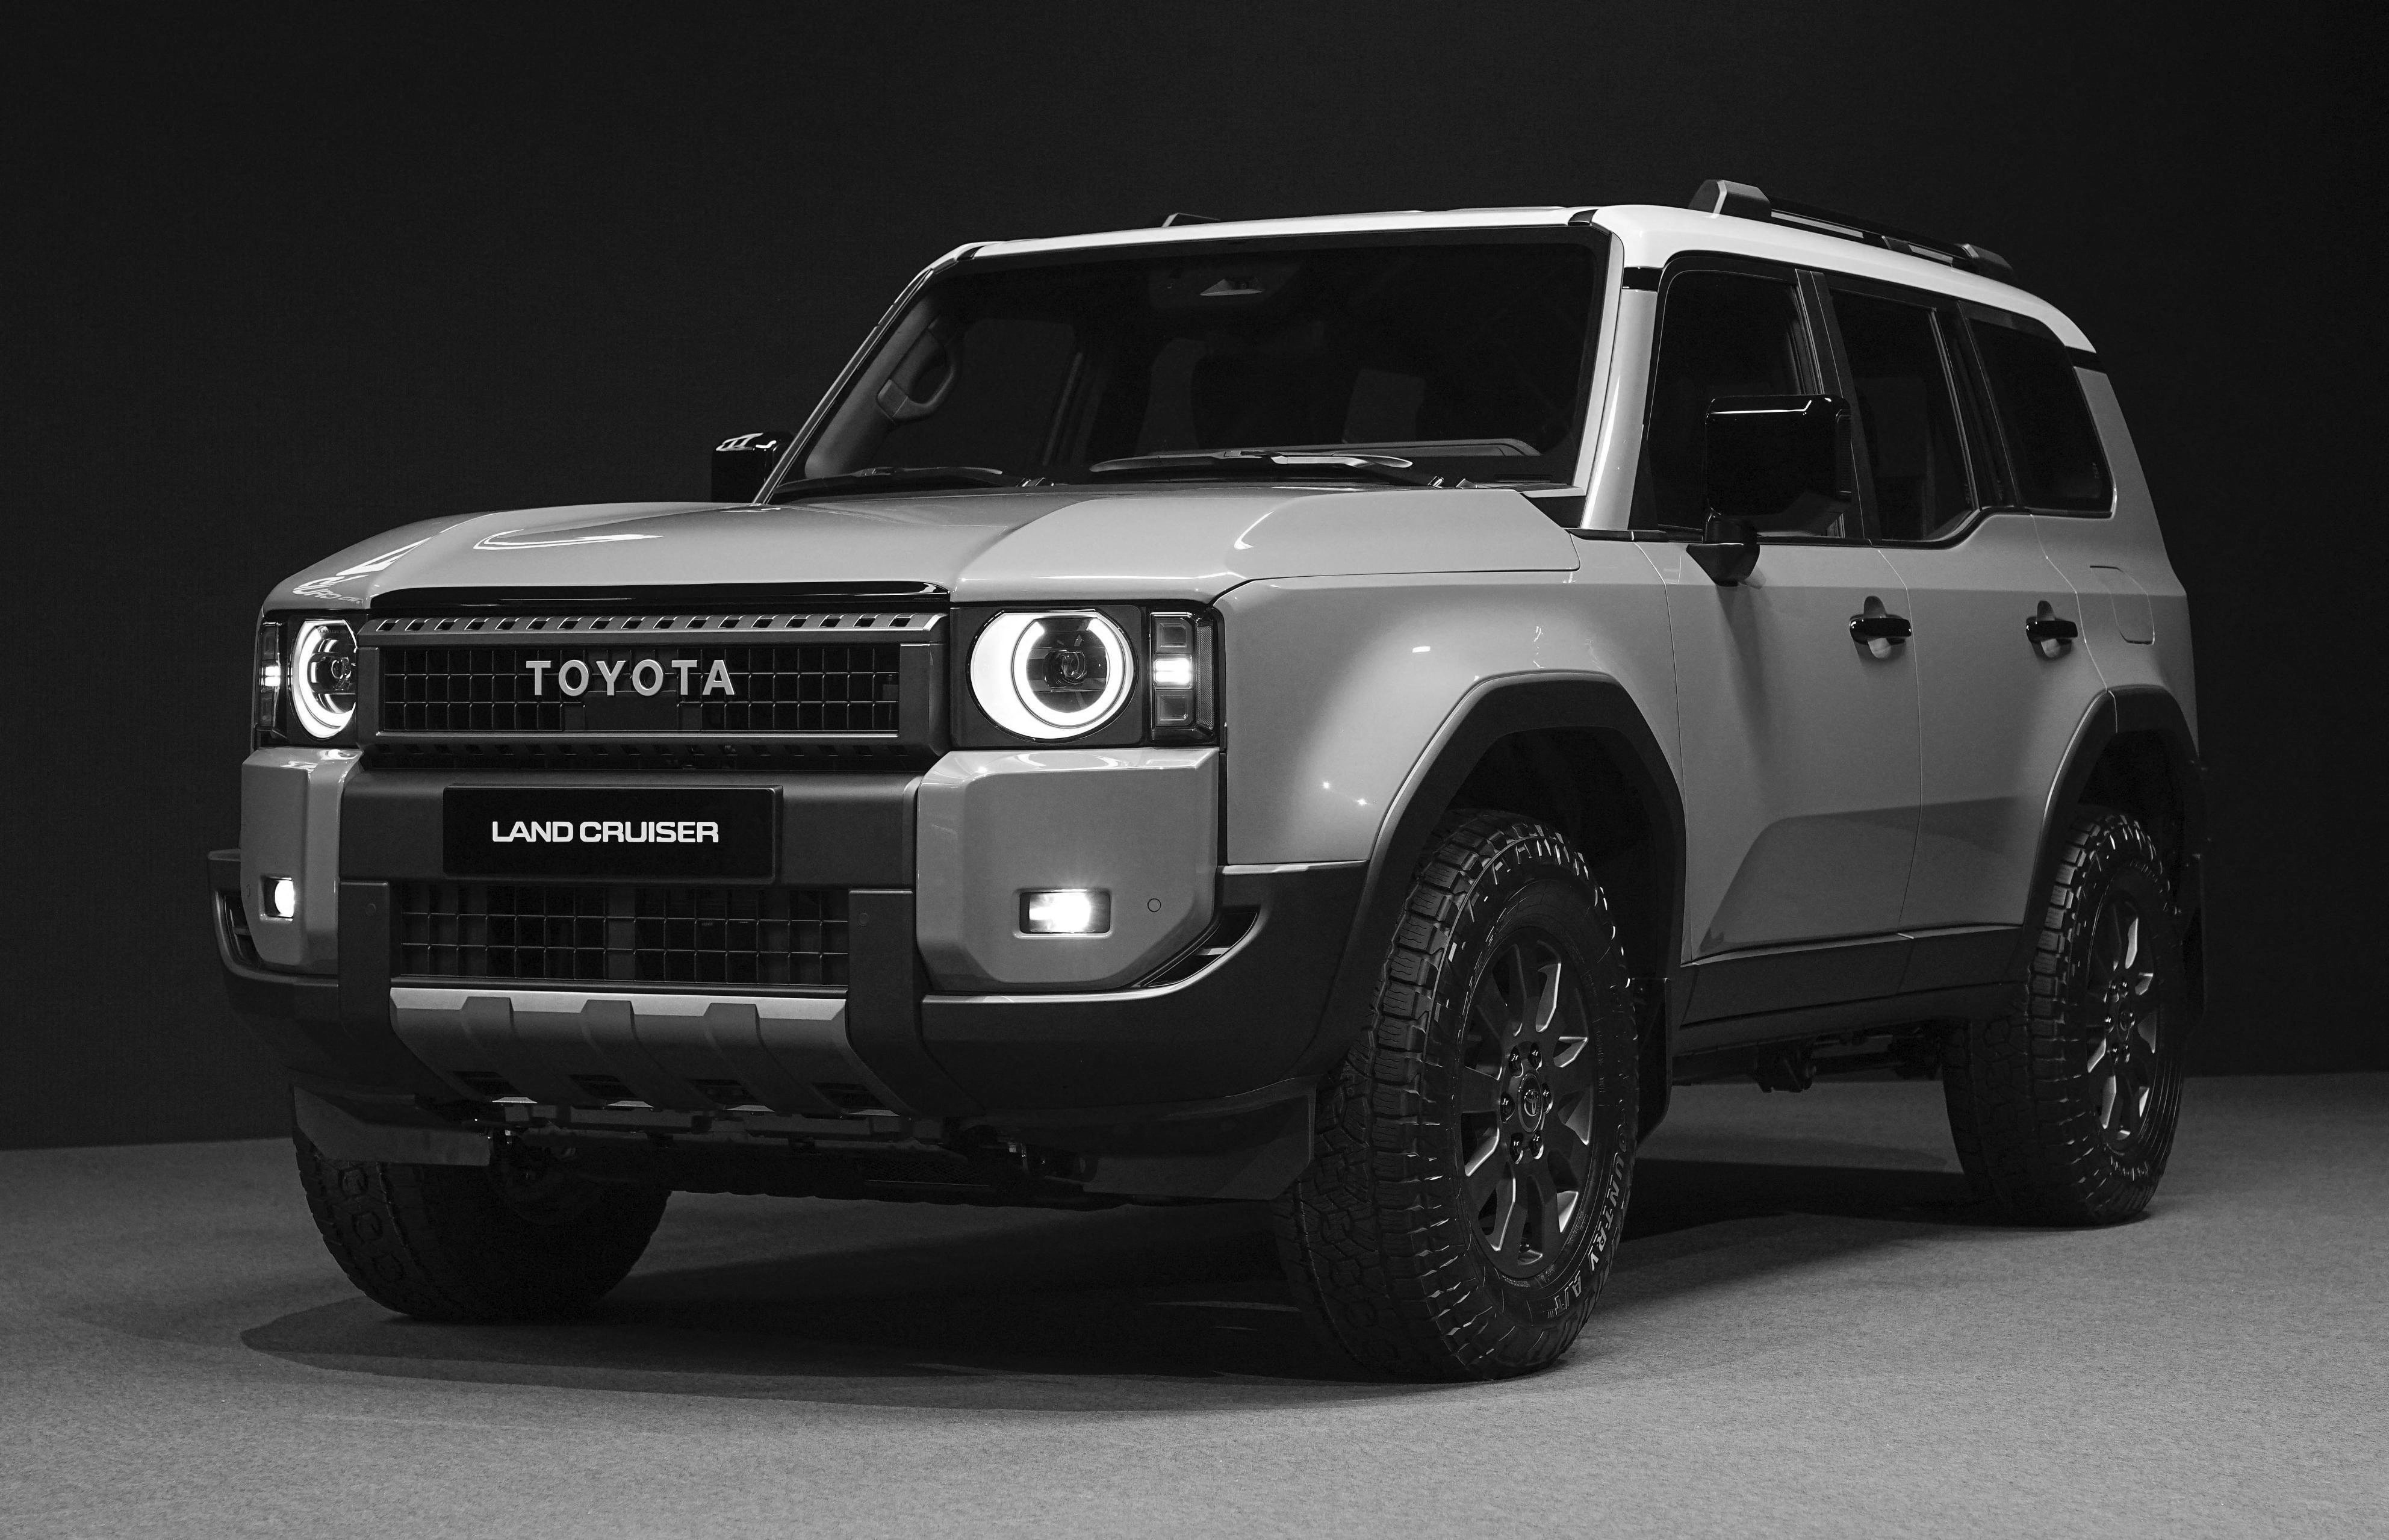

In [ ]:
image_to_asciize

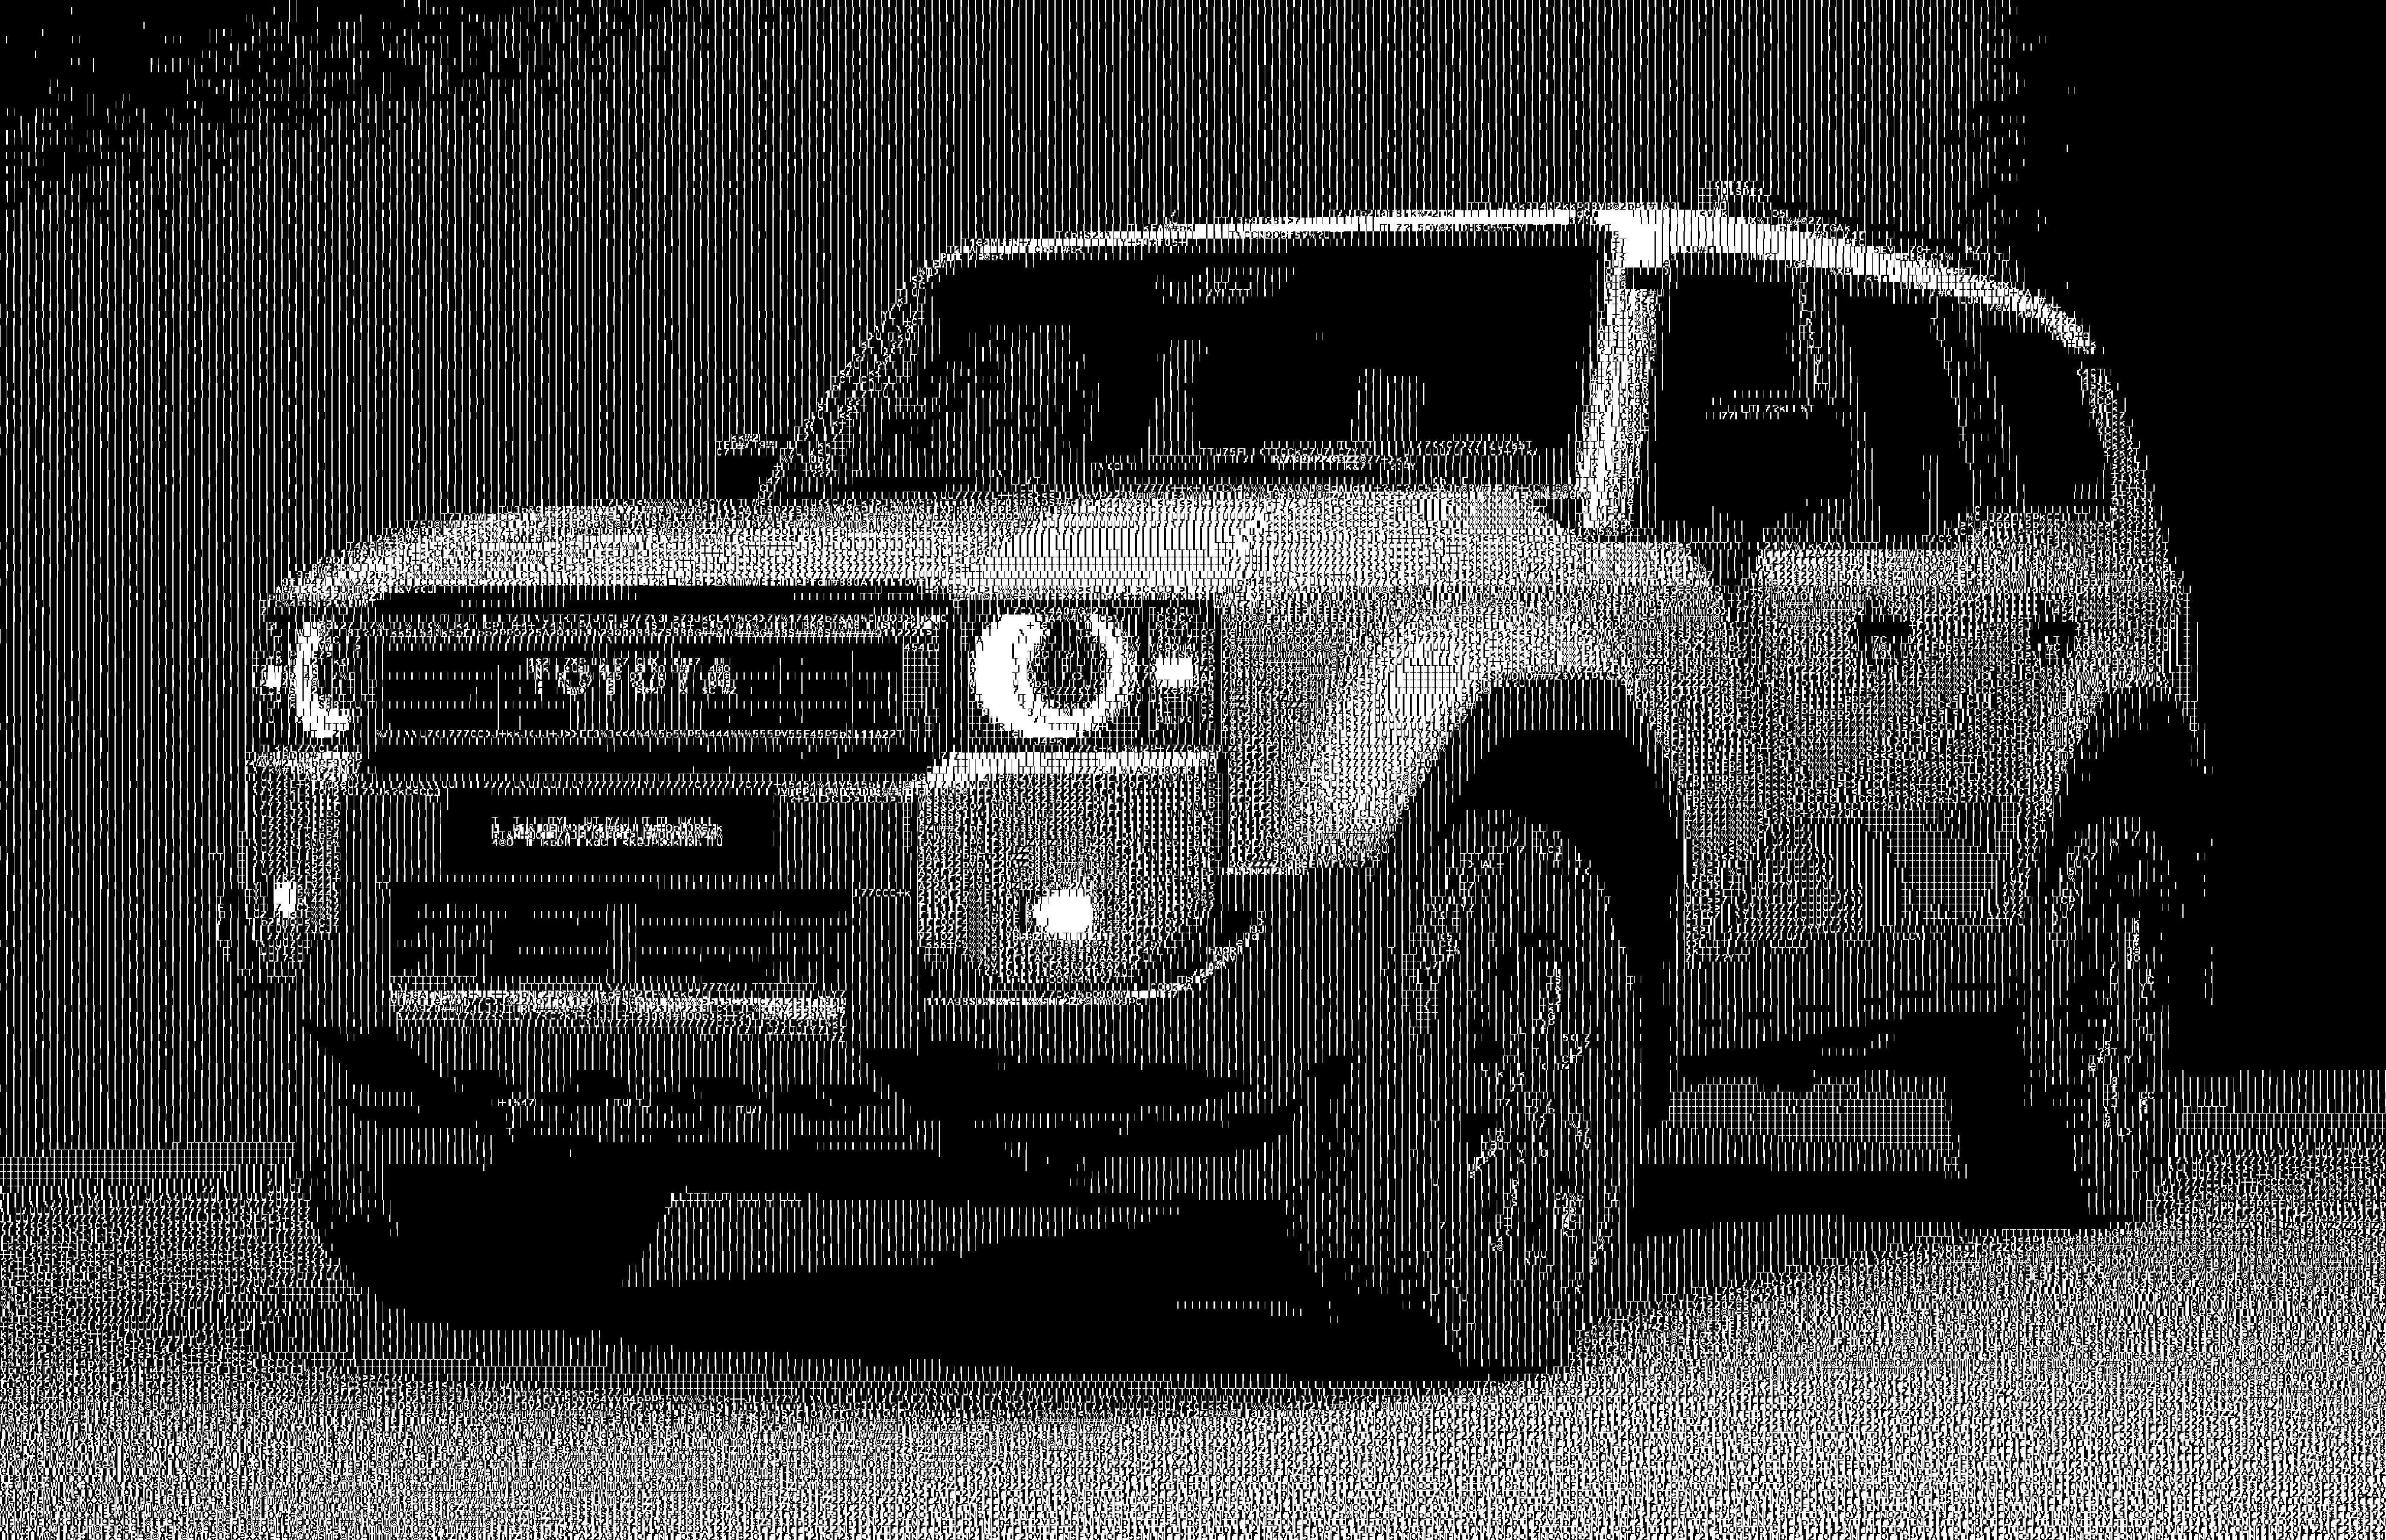

In [ ]:
ascii_image